#  SN1987A:  MIRISim (Imager Prime)

#### This notebook replicates the Imager Prime part of the SN 1987A: The Formation and Evolution of Dust in a Supernova Explosion JWST GTO programme (#1232). 

Details of generating ETC and APT files in this example science program can be found on the JDoX webpages: https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-example-science-programs/miri-mrs-and-nirspec-ifu-observations-of-sn1987a

**Science Objective:** 
The main science goals of this project are to understand how massive stars age and explode, how their ejecta form dust and molecules, and how the blast wave from their violent explosion affects their surroundings. JWST MIRI imaging, and medium resolution spectroscopy (MRS) will provide key emission line diagnostics and dust feature and continuum measurements of SN 1987A. The central stellar ejecta of SN 1987A is surrounded by a ring of progenitor gas and dust that is being shocked by the blast wave of the explosion. A large quantity (0.4–0.7 solar masses; Matsuura et al. 2011) of dust in the stellar ejecta has an unknown composition, and these observations may provide the first constraints through imaging and spatially resolved spectroscopy. 

**In this notebook**, we create a scene with a cold blackbody ~ 20K replicating the inner ejecta of SN 1987A and a ring of warm (~ 100K) silicate dust and atomic emission lines surrounding the ejecta, and run through a MIRISim simulation showing the products created at each stage.

**NOTE** this notebook must be started within  the correct anaconda environment in which you have MIRISim installed. This is a prerequisite for using MIRISim, and installation instructions can be found [here](http://miri.ster.kuleuven.be/bin/view/Public/MiricleInstallation).

When launching the notebook, make sure in the right Anaconda environment. i.e. type

<code> source activate miricle </code> 

in the terminal before starting the notebook.

### Steps in this notebook:

0. Import useful python packages
1. Create a Scene
2. Initialise the simulation parameters
3. Run the simulation
4. Examine some of the outputs.  

## Step 0 - Some general python housekeeping
### Import useful python packages

In [1]:
# Import usefull python packages
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

# Import python packages used to display images inline in the notebook
import matplotlib.pyplot as plt    
from matplotlib import colors,cm
%matplotlib inline       

######################################
# Now import MIRISim specific packages 

# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics, ExternalSed
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation         

### Define some common functions 

1) <code>save_to_fits</code> - Used to save the generated scene to a fits file

2) <code>show_outputs</code> - Used in plotting outputs from MIRISim

In [2]:
def save_to_fits(scene, light_path, filename='MIRISim_scene.fits', SpatialSampling=0.1, WavelengthRange=None, 
                 WavelengthSampling=0.1):
    """
    Function to save the MIRISim scene to a fits file.
    
    :param filename: Name of file to save - default is "MIRISim_scene.fits"
    :type filename: string       
    
    :param SpatialSampling: Spatial sampling (in arcsec) - default is 0.1 arcseconds
    :type SpatialSampling: float
    
    :param WavelengthRange: Wavelength range to process (in microns) - default is [5, 28] microns
    :type WavelengthRange: array
    
    :param WavelengthSampling: Channel width (in microns) - default is 0.1 arcseconds
    :type WavelengthSampling: float
    
    :rtype: None
    :raises Exception: when light_path parameter not set to MRS or IMA
    """
    
    # Avoids array being extended inside function for mutliple calls. Python gotcha
    if WavelengthRange is None:
        WavelengthRange = [5, 28]
        
    if light_path == 'IMA':
        # IMA Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-57., 57.],[-57., 57.]])   
    elif light_path == "MRS":
        # MRS Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-4., 4.],[-4., 4.]])       
    else:
        raise Exception('Acceptable inputs for parameter light_path are [IMA] and [MRS]')
    
    # overwrite = True enables overwriting of any previous version of the fits file
    # with the same name as that given in the writecube command
    scene.writecube(cubefits = filename,
                    FOV = FOV, time = 0.0,
                    spatsampling = SpatialSampling,
                    wrange = WavelengthRange,
                    wsampling = WavelengthSampling,
                    overwrite = True) 

In [3]:
def show_outputs(MIRISim_outputdir,output_type):
    """
    Plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    """
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    
    if output_type.lower() == 'skycubes': 
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        central_chan = datashape[0]//2
        
        plt.imshow(hdulist[hdu_index].data[central_chan,:,:],
           origin = 'lower', interpolation = 'nearest',cmap = cm.viridis, aspect='equal')
        plt.title('channel {} of {}'.format(central_chan,infits.split('/')[-1]))
        plt.xlabel(hdulist[hdu_index].header['ctype1'])
        plt.ylabel(hdulist[hdu_index].header['ctype2'])
    else:
        hdu_index = 1
        if len(hdulist[hdu_index].data.shape) > 2:
            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        else:
            image = hdulist[hdu_index].data
            
        
        plt.imshow(image, origin = 'lower',cmap = cm.viridis,interpolation='nearest', aspect='equal')
        plt.title('{}'.format(infits.split('/')[-1]))
        plt.xlabel('Along Slice Direction')
        plt.ylabel('Wavelength Direction')

    plt.colorbar()

### Set flags for saving the MIRISim scene to a fits file - default is False 
We select false as the default as 1) a fits file of the scene is not necessary to run mirisim; 2) this step can take a long time to run; 3) once a scene has been saved as a fits file one this step is not necessary.

In [4]:
save_scene_as_fits = False

## Step 1 - Create a Scene - this represents your science observation

Each scene should include at minimum: 1) A background level; 2) A science source

The scene created below consists of a cold ~ 20K blackbody replicating the inner ejecta of SN1987A and a ring of warm silicate dust surrounding the ejecta that all of which fit within the MRS field of view. The first point source has a 20 K blackbody SED, the ring has a SED imported from Spitzer IRS observations. 



### Reference numbers for the MIRI Imager FOV

MIIR Imager array size  = 1024 × 1032  pixels. 

                        = (1,1) lower left, 
                        (1,1024) top left,
                        (1032, 1024), top right,
                        (1032, 1) lower right.  

MIRI Imager FULL FOV = 74 × 113  arcseconds        

#### Create a low level background for the scene

In [5]:
bg = Background(level='low',gradient=9., pa=45.)

2021-04-27 17:29:07,898 - INFO - Initializing Background


#### Create the First Point Source - replicating the cold (~20 K) dust in the inner ejecta - Flux values and tempratures from Matsuura et al. 2011



In [6]:
# Initialise a single point source at the central position of the MIRI MRS
"""
MIRI MRS FOV     = 3.7 × 3.7  arcseconds  in ALL four channels 
Max MIRI MRS FOV = 7.2 × 7.9  arcseconds  
"""
point1 = Point(Cen = (0.0,0.0))

# Set properties of the SED for point 1
Blackbody = sed.BBSed(Temp = 26., wref = 20., flux = 45.4 * 1000)  # Temp = K, wref = microns, flux = micro Jy 

# Add the SED to the point source
point1.set_SED(Blackbody)

# Add ejecta (point1) to the compound target list called 'sn1987A_components' for creating a scene
sn1987A_components = point1

# For writing to scene.ini file
targetlist = [point1]


2021-04-27 17:29:07,904 - INFO - Initializing Point


### Create the ring surrounding the ejecta 

#### 1) First import the SED from an external file

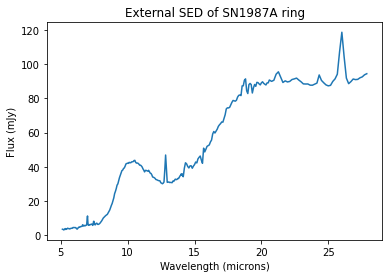

In [7]:
# Get SEDs of the ring for SN1987A observed with Spitzer IRS. Data from Jones et al. 2017b 

# Use: sedfile =  ExternalSed('extsed.txt') # filepath, columns 'wavelength' [microns] and 'flux' [muJy]
ring_sed = ExternalSed(sedfile = 'SN1987A_ring_microJy.txt') 

# For zooming in on spectral ranges
l_min = 5 #micron
l_max = 28 #micron
sp_min = np.abs(ring_sed.Lam-l_min).argmin()
sp_max = np.abs(ring_sed.Lam-l_max).argmin()

# Plot the Spitzer spectrum of the SN1987A ring component for refrence
fig = plt.figure(figsize=(8, 6))
ax = plt.subplots()[1]  
ax.plot(ring_sed.Lam[sp_min:sp_max], ring_sed.fLam[sp_min:sp_max])   
ax.set_xlabel("Wavelength (microns)")  
ax.set_ylabel("Flux (mJy)")  
ax.set_title("External SED of SN1987A ring")  
plt.close(fig)

#### 2) Then attach the SED to an object

In [8]:
# Set up the spatial distibution of the ring of SN1987A

# Create a ring of sources and add them to the scene
MRS_radius = 3.2/2.   # Radius of MRS (in arcsec)             
Nring = 16            # Number of ring components to put within the MRS 

# Create a circle of resolved objects to replicate the ring, add the SED to each object and add to the scene
for i in range(0,Nring):
      
    xp = np.cos(2*np.pi/Nring*i)*MRS_radius
    yp = np.sin(2*np.pi/Nring*i)*MRS_radius
    
    # Initlise a ring using the galaxy template of a non-pointsource 
    ring = Galaxy(Cen = (xp,yp),n=0.5,re=0.15,q=0.33,pa=360/Nring*i)  # n = sersic idx; re = eff. rad. [arcsec] ; q = axis ratio
 
   
#     # Test to work out why ring galaxy object causing simulation to crash
    
#     # set the properties of the SED
#     ring_sed = sed.PLSed(alpha=1.0,flux=5e5,wref=10.)
#     # add the SED to the galaxy
#     ring.set_SED(ring_sed)
    
    
#     # create a velocity mapping for the SED
#     VMAPpars = {'vrot': 200., 'Cen': (0., -0.5), 'pa': 90., 'q': 0.1, 'c': 0}
#     VelocityMap = kinetics.FlatDisk(**VMAPpars)
#     # add the velocity map to the galaxy
#     ring.set_velomap(VelocityMap)
    
#     # add a line of sight velocity distribution to the galaxy
#     losVeloDist = kinetics.Losvd(sigma=200.,h3=0.,h4=0.)
#     ring.set_LOSVD(losVeloDist)
    
    # Add the Spitzer IRS observtions of the ring from Jones et al 2017b to generate the SED of initialised ring
    ring.set_SED(ring_sed)

    sn1987A_components += ring    # For creating a scene
    targetlist.append(ring)       # For writing to scene.ini file

2021-04-27 17:29:08,091 - INFO - Initializing Galaxy
2021-04-27 17:29:08,092 - INFO - Initializing Galaxy
2021-04-27 17:29:08,093 - INFO - Initializing Galaxy
2021-04-27 17:29:08,094 - INFO - Initializing Galaxy
2021-04-27 17:29:08,094 - INFO - Initializing Galaxy
2021-04-27 17:29:08,095 - INFO - Initializing Galaxy
2021-04-27 17:29:08,095 - INFO - Initializing Galaxy
2021-04-27 17:29:08,096 - INFO - Initializing Galaxy
2021-04-27 17:29:08,096 - INFO - Initializing Galaxy
2021-04-27 17:29:08,097 - INFO - Initializing Galaxy
2021-04-27 17:29:08,097 - INFO - Initializing Galaxy
2021-04-27 17:29:08,098 - INFO - Initializing Galaxy
2021-04-27 17:29:08,098 - INFO - Initializing Galaxy
2021-04-27 17:29:08,099 - INFO - Initializing Galaxy
2021-04-27 17:29:08,099 - INFO - Initializing Galaxy
2021-04-27 17:29:08,100 - INFO - Initializing Galaxy
2021-04-27 17:29:08,100 - INFO - Initializing Galaxy
2021-04-27 17:29:08,101 - INFO - Initializing Galaxy
2021-04-27 17:29:08,101 - INFO - Initializing 

### From the components, create a scene

To create a scene adding together the background and targets i.e the ejecta component and the ring components.

In [9]:
scene = bg +  sn1987A_components

### Export the scene to an ini file and FITS file (optional)

Export scene to an ini file (for future use), or a FITS file to be visualised. This stage is not necessary if runing mirisim in a notebook.

Exporting to a FITS file requires specifing a number of aditional parametrs such as the Field of view, required spectral sampling, etc. They're described in more detail below. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes)


In [10]:
# Used to run MIRISim within notebook
scene_config = SceneConfig.makeScene(loglevel=0,
                                    background=bg,
                                    targets = targetlist)

# Export to ini file - not necessary if runing mirisim in notebook
os.system('rm -fr MRS_SN1987A_scene.ini')      # Remove previous version of .ini file
scene_config.write('MRS_SN1987A_scene.ini')

## Initialise the MIRI imager Simulation Parameters


### SN1987A imager obsevation set up:

For SN 1987A we want to simulate the F560W, F1000W, F1800W, F2550W filters 

1. Dither = 4pt 
2. Read out mode = <code>FAST</code> selected based on best practices. 
3. Portion of detector to read out = <code>BRIGHTSKY</code> to prevent saturation


#### Filters  -   Groups - Integrations
- F560W:  16 groups and 18 integrations
- F1000W: 14 groups and 16 integrations 
- F1800W: 14 groups and 16 integrations
- F2550W: 14 groups and 20 integrations

###  F1000W Filter - Skiping F560W as ring data spectra starts mid filter

In [14]:
sim_config = SimConfig.makeSim(
    name = 'MIRI_IMA_SN1987A_F1000W',                # name given to simulation
    scene = 'MRS_SN1987A_scene.ini',                 # name of scene file to input
    rel_obsdate = 0.0,                               # relative observation date (0 = launch, 1 = end of 5 yrs)
    
    POP = 'IMA',                # Component on which to center (Imager or MRS)
    ConfigPath = 'IMA_FULL',    # Configure the Optical path (MRS sub-band)
    
    Dither = True,              # Dither  - use false for test case 
    StartInd = 1,               # Start index for dither pattern
    NDither = 4,                # Number of dither positions
    DitherPat = 'ima_recommended_dither.dat', # dither pattern to use 
        
    ima_exposures = 1,          # number of exposures
    ima_integrations = 16,      # number of integrations
    ima_frames = 14,            # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',          # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'F1000W',          # Imager Filter to use
    #readDetect = 'BRIGHTSKY',   # Portion of detector to read out
    readDetect = 'FULL',   # Portion of detector to read out
    
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 2,          # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 5              # [NOT USED HERE]    
    
)

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.
The last step is to setup the defaults for internal things like CDPs.

In [15]:
# Get the simulation configuration perameters using the default setup
simulator_config = SimulatorConfig.from_default()

In [16]:
mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()

2021-04-27 17:31:18,856 - INFO - MIRISim version: 2.4.0
2021-04-27 17:31:18,857 - INFO - MIRI Simulation started.
2021-04-27 17:31:18,858 - INFO - Output will be saved to: 20210427_173118_mirisim
2021-04-27 17:31:18,859 - INFO - Storing configs in output directory.
2021-04-27 17:31:18,863 - INFO - Storing dither pattern in output directory.
2021-04-27 17:31:18,865 - INFO - Using $CDP_DIR for location of CDP files: /Users/ojones/Desktop/mirisim_egs/CDP
2021-04-27 17:31:18,866 - INFO - Setting up simulated Observation, with following settings:
2021-04-27 17:31:18,867 - INFO - Configuration Path: IMA_FULL
2021-04-27 17:31:18,867 - INFO - Primary optical path: IMA
2021-04-27 17:31:18,868 - INFO - IMA Filter: F1000W
2021-04-27 17:31:18,869 - INFO - IMA Subarray: FULL
2021-04-27 17:31:18,870 - INFO - IMA detector readout mode: FAST
2021-04-27 17:31:18,871 - INFO - IMA detector # exposures: 1
2021-04-27 17:31:18,872 - INFO - IMA detector # integrations: 16
2021-04-27 17:31:18,873 - INFO - IMA

2021-04-27 17:31:20,582 - INFO - Processing point sources for IMAGER 
2021-04-27 17:33:21,812 - INFO - No SkyCube
2021-04-27 17:33:21,823 - INFO - Reading 'SKYFLAT' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIMAGE_F1000W_SKYFLAT_07.00.00.fits'
2021-04-27 17:33:21,890 - INFO - Apply Footprint
2021-04-27 17:33:21,891 - INFO - Retrieving Foot Print from PIXELFLAT
2021-04-27 17:33:21,892 - INFO - Reading 'PIXELFLAT' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIMAGE_SLOW_F1000W_PIXELFLAT_07.01.01.fits'
2021-04-27 17:33:22,036 - INFO - Wrote illumination model: 20210427_173118_mirisim/illum_models/illum_model_seq1_MIRIMAGE_F1000W.fits
2021-04-27 17:33:22,038 - INFO - Simulating integrated detector images for Imager exposures for pointing 1
2021-04-27 17:33:22,039 - INFO - Simulating Imager exposure 1
2021-04-27 17:33:22,041 - INFO - Running SCASim
2021-04-27 17:33:22,042 - INFO - Simulating  detector readout for MIRIMAGE from illumination data model of shap

2021-04-27 17:37:01,963 - WARNING - ***Illumination map of size 1024 x 1032 is too large! Truncating to detector size of 1024 x 1024 pixels.
2021-04-27 17:37:01,965 - INFO - Input subarray mode obtained from illumination map: FULL
2021-04-27 17:37:01,966 - INFO - Detector properties translates input subarray FULL into None
2021-04-27 17:37:01,970 - INFO - Reading 'MASK' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIMAGE_MASK_07.02.01.fits'
2021-04-27 17:37:02,012 - INFO - Reading 'GAIN' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIMAGE_GAIN_04.00.00.fits'
2021-04-27 17:37:02,132 - INFO - Reading DARK model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIMAGE_FAST_DARK_06.01.00.fits'
2021-04-27 17:37:06,089 - INFO - Reading 'PIXELFLAT' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIMAGE_FAST_F1000W_PIXELFLAT_07.01.01.fits'
2021-04-27 17:37:06,202 - INFO - Reading 'LINEARITY' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM

2021-04-27 17:41:17,411 - INFO - Simulating 14 groups for integration 10.
2021-04-27 17:41:21,087 - INFO - Simulating 14 groups for integration 11.
2021-04-27 17:41:24,760 - INFO - Simulating 14 groups for integration 12.
2021-04-27 17:41:28,459 - INFO - Simulating 14 groups for integration 13.
2021-04-27 17:41:32,129 - INFO - Simulating 14 groups for integration 14.
2021-04-27 17:41:35,811 - INFO - Simulating 14 groups for integration 15.
2021-04-27 17:41:39,492 - INFO - Simulating 14 groups for integration 16.
2021-04-27 17:41:43,099 - INFO - Adding the DARK calibration from /Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIMAGE_FAST_DARK_06.01.00.fits
2021-04-27 17:41:46,056 - INFO - Correcting nonlinearity from MIRI_FM_MIRIMAGE_LINEARITY_06.02.00.fits
2021-04-27 17:41:56,055 - INFO - Output subarray undefined or FULL. SUBSTRT=(1,1), SUBSIZE=(1032,1024)
2021-04-27 17:41:56,056 - INFO - WCS keywords defined as CRPIX1=0, CRPIX2=0
2021-04-27 17:41:59,479 - INFO - Exposure time 621.61s 

## Examine some of the results

Outputs are in a date-labelled directory taking the form  <code>YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

### The results of the F1000W imager simulation are contained in the most recent directory.

In [ ]:
outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

In [ ]:
outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the output directory are:\n{}'.format(directories))
print('\nThe files in the output directory are:\n{}'.format(files))

The files contain the log which was also output to the terminal (<code>mirisim.log</code>) and the .ini files used to create the simulation. These versions of the .ini files can be used to re-create the run of the simulation.

The directories contain various outputs of MIRISim:

* **<code> illum_models </code>** houses FITS images of the illuminations sent to the detector (sent to SCAsim - the simulator of the Sensor Chip Assembly).  This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position
* **<code> det_images </code>** houses FITS images of the final outputs of MIRISim. These detector images have all of the detector effects and noise incorporated. The number of detector images should be the same as the number of illumination models. 

The headers of the detector images are formatted for ingest into the JWST pipeline. 


In [ ]:
show_outputs(outputdir,'det_images')

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
hdulist[1].header

### F1800W Filter

In [ ]:
sim_config = SimConfig.makeSim(
    name = 'MIRI_IMA_SN1987A_F1800W',                # name given to simulation
    scene = 'MRS_SN1987A_scene.ini',                 # name of scene file to input
    rel_obsdate = 0.0,                               # relative observation date (0 = launch, 1 = end of 5 yrs)
    
    POP = 'IMA',                # Component on which to center (Imager or MRS)
    ConfigPath = 'IMA_FULL',    # Configure the Optical path (MRS sub-band)
    
    Dither = True,              # Dither  - use false for test case 
    StartInd = 1,               # Start index for dither pattern
    NDither = 4,                # Number of dither positions
    DitherPat = 'ima_recommended_dither.dat', # dither pattern to use 
        
    ima_exposures = 1,          # number of exposures
    ima_integrations = 16,      # number of integrations
    ima_frames = 14,            # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',          # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'F1800W',          # Imager Filter to use
    readDetect = 'BRIGHTSKY',   # Portion of detector to read out
    
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 2,          # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 5              # [NOT USED HERE]    
    
)

In [ ]:
# Get the simulation configuration perameters using the default setup
simulator_config = SimulatorConfig.from_default()

In [ ]:
mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()

### F2500W Filter

In [ ]:
sim_config = SimConfig.makeSim(
    name = 'MIRI_IMA_SN1987A_F1000W',                # name given to simulation
    scene = 'MRS_SN1987A_scene.ini',                 # name of scene file to input
    rel_obsdate = 0.0,                               # relative observation date (0 = launch, 1 = end of 5 yrs)
    
    POP = 'IMA',                # Component on which to center (Imager or MRS)
    ConfigPath = 'IMA_FULL',    # Configure the Optical path (MRS sub-band)
    
    Dither = True,              # Dither  - use false for test case 
    StartInd = 1,               # Start index for dither pattern
    NDither = 4,                # Number of dither positions
    DitherPat = 'ima_recommended_dither.dat', # dither pattern to use 
        
    ima_exposures = 1,          # number of exposures
    ima_integrations = 20,      # number of integrations
    ima_frames = 14,            # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',          # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'F2500W',          # Imager Filter to use
    readDetect = 'BRIGHTSKY',   # Portion of detector to read out
    
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 2,          # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 5              # [NOT USED HERE]    
    
)

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.
The last step is to setup the defaults for internal things like CDPs.

# Get the simulation configuration perameters using the default setup
simulator_config = SimulatorConfig.from_default()

mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()

In [ ]:
# Get the simulation configuration perameters using the default setup
simulator_config = SimulatorConfig.from_default()

In [ ]:
#run Simulation
mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()

## The outputs of MIRISim can now be run through the JWST pipeline see:
###  https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline and https://jwst-pipeline.readthedocs.io/en/stable/